# Numerical Optimization for Logistic Regression.

### - Malav Shastri




1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Logistic/paper/logistic.pdf)
2. **Implement mini-batch SGD** and evaluate the performance.




# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()
print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [2]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [3]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.04540135 -0.01369003  0.05249806  0.25365942  0.05483595  0.01434998
   0.09056953 -0.14876039]]
test std = 
[[1.05040587 0.88829682 0.74827023 1.04310982 0.82997582 0.95468772
  1.00965742 0.84343128]]


## 1.4. Add a dimension of all ones

In [4]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


# 2. Logistic regression model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

In [5]:
# Calculate the objective function value
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     objective function value (scalar)
def objective(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(-yxw) # n-by-1 matrix
    vec2 = numpy.log(1 + vec1) # n-by-1 matrix
    loss = numpy.mean(vec2) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    return loss + reg
    

In [6]:
# initialize w
d = x_train.shape[1]
w = numpy.zeros((d, 1))

# evaluate the objective function value at w
lam = 1E-6
objval0 = objective(w, x_train, y_train, lam)
print('Initial objective function value = ' + str(objval0))

Initial objective function value = 0.6931471805599453


# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ is $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [7]:
# Calculate the gradient
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     g: g: d-by-1 matrix, full gradient
def gradient(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(yxw) # n-by-1 matrix
    vec2 = numpy.divide(yx, 1+vec1) # n-by-d matrix
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w
    return g

In [8]:
# Gradient descent for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_iter: integer, the maximal iterations
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: d-by-1 matrix, the solution
#     objvals: a record of each iteration's objective value
def grad_descent(x, y, lam, stepsize, max_iter=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_iter) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_iter):
        objval = objective(w, x, y, lam)
        objvals[t] = objval
        print('Objective value at t=' + str(t) + ' is ' + str(objval))
        g = gradient(w, x, y, lam)
        w -= stepsize * g
    
    return w, objvals

Run gradient descent.

In [9]:
lam = 1E-6
stepsize = 1.0
w, objvals_gd = grad_descent(x_train, y_train, lam, stepsize)

Objective value at t=0 is 0.6931471805599453
Objective value at t=1 is 0.593546739632974
Objective value at t=2 is 0.5513132686706287
Objective value at t=3 is 0.5281436092689923
Objective value at t=4 is 0.5135402440468784
Objective value at t=5 is 0.5036050050080867
Objective value at t=6 is 0.4965191326818466
Objective value at t=7 is 0.4913002296349463
Objective value at t=8 is 0.4873642759862306
Objective value at t=9 is 0.4843407055733217
Objective value at t=10 is 0.48198320707401676
Objective value at t=11 is 0.48012224794205016
Objective value at t=12 is 0.47863789334250767
Objective value at t=13 is 0.47744336927843695
Objective value at t=14 is 0.4764746961311756
Objective value at t=15 is 0.4756839290066707
Objective value at t=16 is 0.4750346277613775
Objective value at t=17 is 0.4744987502560404
Objective value at t=18 is 0.47405447859747374
Objective value at t=19 is 0.47368467107544227
Objective value at t=20 is 0.47337574214575073
Objective value at t=21 is 0.473116840

## 3.2. Stochastic gradient descent (SGD)

Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [10]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    d = xi.shape[0]
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar
    
    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

In [11]:
# SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def sgd(x, y, lam, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

Run SGD.

In [12]:
lam = 1E-6
stepsize = 0.1
w, objvals_sgd = sgd(x_train, y_train, lam, stepsize)

Objective value at epoch t=0 is 0.5488024744090566
Objective value at epoch t=1 is 0.5107241884646065
Objective value at epoch t=2 is 0.5171523590559483
Objective value at epoch t=3 is 0.5058948531354687
Objective value at epoch t=4 is 0.5065010727183126
Objective value at epoch t=5 is 0.5035844998559206
Objective value at epoch t=6 is 0.504308603389608
Objective value at epoch t=7 is 0.4971475476500876
Objective value at epoch t=8 is 0.49545374039769874
Objective value at epoch t=9 is 0.4948116989687669
Objective value at epoch t=10 is 0.4920849858616049
Objective value at epoch t=11 is 0.493664378861539
Objective value at epoch t=12 is 0.48840062934494827
Objective value at epoch t=13 is 0.4878207272253533
Objective value at epoch t=14 is 0.48493979526417164
Objective value at epoch t=15 is 0.48339407303737136
Objective value at epoch t=16 is 0.48286321805106247
Objective value at epoch t=17 is 0.483089385158414
Objective value at epoch t=18 is 0.4821458205609295
Objective value at e

# 4. Compare GD with SGD

Plot objective function values against epochs.

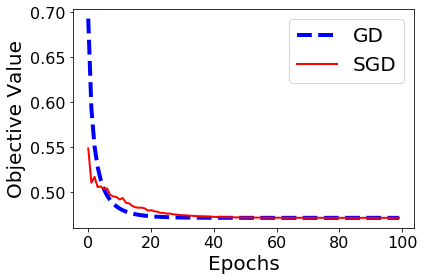

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1], ['GD', 'SGD'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)

# 5. Prediction

In [14]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

In [15]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.2125


In [16]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.21875


# 6. Mini-batch SGD 



## 6.1. Compute the objective $Q_I$ and its gradient using a batch of samples

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [17]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: d-by-1 matrix
#     xi: b-by-d matrix
#     yi: b-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def mb_stochastic_objective_gradient(w, xi, yi, lam, b):
    n,d = xi.shape
    yx = numpy.multiply(yi,xi) # b-by-d matrix
    yxw = numpy.dot(yx, w) # b-by-1 matrix
    
    # calculate objective function Q_i
    vec = numpy.log(1 + numpy.exp(-yxw)) # b-by-1 matrix
    loss = numpy.mean(vec)  # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    vec1 = numpy.exp(yxw) # n-by-1 matrix
    vec2 = numpy.divide(yx, 1+vec1) # n-by-d matrix
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w
    
    return obj, g

## 6.2. Implement mini-batch SGD


1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_stochastic_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.


In [2]:
# Mini-Batch SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def mb_sgd(x, y, lam, b, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    for e in range(max_epoch):
        rand_indices = numpy.random.permutation(n)
        objval = 0
        for i in range(int(n/b)):
            x_mb = x[rand_indices[i*b:i*b+b], :] #Sequentially selects 8 training feature vector samples
            y_mb = y[rand_indices[i*b:i*b+b], :] 
            obj, g = mb_stochastic_objective_gradient(w, x_mb, y_mb, lam, b)
            objval+=obj
            w -= stepsize*g
        stepsize *= 0.9 # decrease step size
        objval*=b/n
        objvals[e]=objval
        print('Objective value at epoch e=' + str(e) + ' is ' + str(objval))
   
    # Record one objective value per epoch (not per iteration!)
    ...
    
    return w, objvals

## 6.3. Run MB-SGD

In [19]:
# MB-SGD with batch size b=8
lam = 1E-6 
b = 8
stepsize = 0.66

w, objvals_mbsgd8 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch e=0 is 0.5232180362065325
Objective value at epoch e=1 is 0.5076657721382241
Objective value at epoch e=2 is 0.5088738394610964
Objective value at epoch e=3 is 0.499008361147419
Objective value at epoch e=4 is 0.5067436036804142
Objective value at epoch e=5 is 0.49428631213203045
Objective value at epoch e=6 is 0.49729642873187924
Objective value at epoch e=7 is 0.49307664578084265
Objective value at epoch e=8 is 0.49404508494328775
Objective value at epoch e=9 is 0.49162547815718094
Objective value at epoch e=10 is 0.4892495469953799
Objective value at epoch e=11 is 0.48749907334567305
Objective value at epoch e=12 is 0.4854145091717561
Objective value at epoch e=13 is 0.48373430921099914
Objective value at epoch e=14 is 0.4844772631002632
Objective value at epoch e=15 is 0.481873534675601
Objective value at epoch e=16 is 0.48031847223954416
Objective value at epoch e=17 is 0.4800881524217763
Objective value at epoch e=18 is 0.47924315428458597
Objective value

In [20]:
# MB-SGD with batch size b=64
lam = 1E-6 
b = 64 
stepsize = 0.71 

w, objvals_mbsgd64 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch e=0 is 0.5547279889252137
Objective value at epoch e=1 is 0.49072523233764453
Objective value at epoch e=2 is 0.4822130556877988
Objective value at epoch e=3 is 0.4774222279359447
Objective value at epoch e=4 is 0.4769911664396038
Objective value at epoch e=5 is 0.47535267630575995
Objective value at epoch e=6 is 0.47605434284223735
Objective value at epoch e=7 is 0.4752728860656854
Objective value at epoch e=8 is 0.4749716489889245
Objective value at epoch e=9 is 0.4744975945265785
Objective value at epoch e=10 is 0.4741183524009007
Objective value at epoch e=11 is 0.47431299234731406
Objective value at epoch e=12 is 0.47417566516406223
Objective value at epoch e=13 is 0.4736302838467589
Objective value at epoch e=14 is 0.4731175485878728
Objective value at epoch e=15 is 0.47288894751120164
Objective value at epoch e=16 is 0.4734405389580104
Objective value at epoch e=17 is 0.4729140031327142
Objective value at epoch e=18 is 0.4727875355546175
Objective value 

# 7. Plot and compare GD, SGD, and MB-SGD

compare the following algorithms:

- Gradient descent (GD)

- SGD

- MB-SGD with b=8

- MB-SGD with b=64

Plot ```objective function value``` against ```epochs```. There should be four curves in the plot; each curve corresponds to one algorithm.

Logistic regression with $\ell_2$-norm regularization is a strongly convex optimization problem. All the algorithms will converge to the same solution. **In the end, the ``objective function value`` of the 4 algorithms will be the same. 

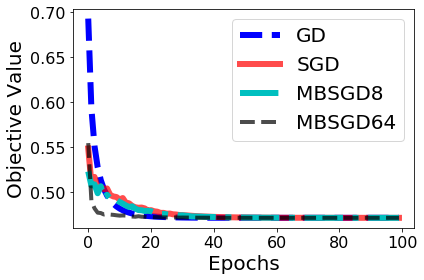

In [21]:
# plot the 4 curves:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))
epochs_mbsgd8 = range(len(objvals_mbsgd8))
epochs_mbsgd64 = range(len(objvals_mbsgd64))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=6)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=6, alpha = 0.7)
line2, = plt.plot(epochs_mbsgd8, objvals_mbsgd8, '-.c', LineWidth=6, alpha = 1)
line3, = plt.plot(epochs_mbsgd64, objvals_mbsgd64, '--k', LineWidth=4, alpha = 0.7)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1, line2, line3], ['GD', 'SGD','MBSGD8', 'MBSGD64'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)